<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

# Importar os módulos

In [1]:
%load_ext autoreload
%autoreload 2
import os
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import Dataset_transf as dprep
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn import metrics, model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss, roc_curve, precision_score, recall_score, confusion_matrix, f1_score, fbeta_score, make_scorer
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import model_selection
import Miguel_class_scaler as mig

# Obter os dataframes dos ficheiros

In [2]:
metrics_dict={}
tentativa = 0
nome_ficheiro = 'Resultados60diassemtresholdnodia16'

In [3]:
failures_df, signals_df, logs_df = dprep.get_data()

In [4]:
failures_df[failures_df.Timestamp >= '2017-06-01']

,Turbine_ID,Component,Timestamp
18,T07,HYDRAULIC_GROUP,2017-06-17 11:30:00
19,T01,TRANSFORMER,2017-08-11 13:10:00
20,T06,HYDRAULIC_GROUP,2017-08-19 09:40:00
21,T07,GENERATOR_BEARING,2017-08-20 06:00:00
22,T07,GENERATOR,2017-08-21 14:40:00


In [5]:
failures_df.Component.value_counts()

GENERATOR            7
GENERATOR_BEARING    6
HYDRAULIC_GROUP      5
TRANSFORMER          3
GEARBOX              2
Name: Component, dtype: int64

In [6]:
df_dict = {'failures_df':failures_df, 'signals_df':signals_df, 'logs_df':logs_df}

In [7]:
for key in df_dict:
    print(key, df_dict[key].shape)

failures_df (23, 3)
signals_df (434145, 81)
logs_df (256231, 3)


# Criação de datasets de components

In [8]:
df_generator, df_gen_bear, df_transformer, df_hydraulic, df_gearbox = dprep.component_df_creation(signals_df)

In [9]:
comp_df_dict = {
    'df_generator': df_generator,
    'df_hydraulic': df_hydraulic,
    'df_gen_bear': df_gen_bear,
    'df_transformer': df_transformer,
    'df_gearbox': df_gearbox
}

In [10]:
for key in comp_df_dict:
    print(comp_df_dict[key].shape, key, )

(434145, 45) df_generator
(434145, 34) df_hydraulic
(434145, 45) df_gen_bear
(434145, 36) df_transformer
(434145, 33) df_gearbox


In [11]:
component_list = failures_df.Component.unique()
component_list

array(['GENERATOR', 'HYDRAULIC_GROUP', 'GENERATOR_BEARING', 'TRANSFORMER',
       'GEARBOX'], dtype=object)

# Cópia dos df para só carregar uma vez no ficheiro

In [12]:
comp_prep_df_dict = comp_df_dict.copy()

In [13]:
for key, i in enumerate(comp_prep_df_dict):
    print(key, i)

0 df_generator
1 df_hydraulic
2 df_gen_bear
3 df_transformer
4 df_gearbox


# Merge dos DF com o DF de failures

In [14]:
for i, key in enumerate(comp_prep_df_dict):
    comp_prep_df_dict[key] = dprep.sig_fail_merge_dfs(sig_df=comp_prep_df_dict[key],
                                               fail_df=failures_df,
                                               component=component_list[i])

In [15]:
for key in comp_prep_df_dict:
    print(comp_prep_df_dict[key].shape, key)

(434147, 46) df_generator
(434145, 35) df_hydraulic
(434145, 46) df_gen_bear
(434145, 37) df_transformer
(434145, 34) df_gearbox


# Fillna by turbine

In [16]:
turbine_list = signals_df.Turbine_ID.unique()
turbine_list

array(['T11', 'T06', 'T01', 'T09', 'T07'], dtype=object)

In [17]:
for i, key in enumerate(comp_prep_df_dict):
    comp_prep_df_dict[key] = dprep.fill_na_by_turbine(comp_prep_df_dict[key],
                                                      turbine_list)

C:\Users\ricar\code\RicardoJPedro82\wmillfailprev\notebooks\Dataset_transf.py:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  index['date'] = index['Timestamp']
C:\Users\ricar\code\RicardoJPedro82\wmillfailprev\notebooks\Dataset_transf.py:181: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  df_ = pd.concat([df_, df_final])
C:\Users\ricar\code\RicardoJPedro82\wmillfailprev\notebooks\Dataset_transf.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


In [18]:
for key in comp_prep_df_dict:
    print(comp_prep_df_dict[key].shape, key)

(434147, 47) df_generator
(434145, 36) df_hydraulic
(434145, 47) df_gen_bear
(434145, 38) df_transformer
(434145, 35) df_gearbox


# Criação de Variável alvo

In [19]:
for key in comp_prep_df_dict:
    print(comp_prep_df_dict[key].isna().sum().value_counts(), key)

0    47
dtype: int64 df_generator
0    36
dtype: int64 df_hydraulic
0    47
dtype: int64 df_gen_bear
0    38
dtype: int64 df_transformer
0    35
dtype: int64 df_gearbox


In [20]:
days_list = [60]

In [21]:
for day in days_list:
    for key in comp_prep_df_dict:
        comp_prep_df_dict[key] = dprep.aplic_var_target(comp_prep_df_dict[key], day)

In [22]:
for key in comp_prep_df_dict:
    print(comp_prep_df_dict[key].shape, key)

(434147, 48) df_generator
(434145, 37) df_hydraulic
(434145, 48) df_gen_bear
(434145, 39) df_transformer
(434145, 36) df_gearbox


# Feature selection

In [23]:
gen_features_drop = [
    'Gen_RPM_Max', 'Gen_RPM_Min', 'Gen_Phase1_Temp_Avg', 'Gen_Phase3_Temp_Avg',
    'Amb_WindSpeed_Est_Avg', 'Grd_RtrInvPhase1_Temp_Avg',
    'Grd_RtrInvPhase3_Temp_Avg', 'Rtr_RPM_Max', 'Rtr_RPM_Min',
    'Blds_PitchAngle_Max', 'Blds_PitchAngle_Min',
    'Prod_LatestAvg_ReactPwrGen1', 'Cont_Hub_Temp_Avg', 'Spin_Temp_Avg',
    'Rtr_RPM_Std', 'Rtr_RPM_Avg', 'Cont_VCP_Temp_Avg'
]

In [24]:
gen_bear_features_drop = [
    'Gen_RPM_Max', 'Gen_RPM_Min', 'Gen_Phase1_Temp_Avg', 'Gen_Phase3_Temp_Avg',
    'Amb_WindSpeed_Est_Avg', 'Grd_RtrInvPhase1_Temp_Avg',
    'Grd_RtrInvPhase3_Temp_Avg', 'Rtr_RPM_Max', 'Rtr_RPM_Min',
    'Blds_PitchAngle_Max', 'Blds_PitchAngle_Min',
    'Prod_LatestAvg_ReactPwrGen1', 'Cont_Hub_Temp_Avg', 'Spin_Temp_Avg',
    'Rtr_RPM_Std', 'Rtr_RPM_Avg', 'Cont_VCP_Temp_Avg'
]

In [25]:
hyd_features_drop = [
    'Rtr_RPM_Max', 'Rtr_RPM_Min', 'Blds_PitchAngle_Max', 'Blds_PitchAngle_Min',
    'Blds_PitchAngle_Max', 'Grd_RtrInvPhase3_Temp_Avg', 'Grd_Busbar_Temp_Avg',
    'Amb_WindSpeed_Est_Avg', 'Spin_Temp_Avg', 'Cont_Hub_Temp_Avg',
    'Grd_RtrInvPhase1_Temp_Avg', 'Cont_VCP_Temp_Avg'
]

In [26]:
gearbox_features_drop = [
    'Rtr_RPM_Max', 'Rtr_RPM_Min', 'Grd_RtrInvPhase1_Temp_Avg',
    'Grd_RtrInvPhase3_Temp_Avg', 'Blds_PitchAngle_Min', 'Blds_PitchAngle_Max',
    'Cont_VCP_Temp_Avg', 'Grd_Busbar_Temp_Avg', 'Amb_WindSpeed_Est_Avg',
    'Spin_Temp_Avg'
]

In [27]:
transf_features_drop = [
    'HVTrafo_Phase1_Temp_Avg', 'HVTrafo_Phase3_Temp_Avg', 'Rtr_RPM_Max',
    'Rtr_RPM_Min', 'Grd_RtrInvPhase1_Temp_Avg', 'Grd_RtrInvPhase3_Temp_Avg',
    'Blds_PitchAngle_Min', 'Blds_PitchAngle_Max', 'Amb_WindSpeed_Est_Avg',
    'Spin_Temp_Avg', 'Cont_VCP_Temp_Avg'
]

In [28]:
feat_drop_list = [
    gen_features_drop, hyd_features_drop, gen_bear_features_drop,
    transf_features_drop, gearbox_features_drop
]

In [29]:
for i, key in enumerate(comp_prep_df_dict):
    print(f'A actualizar dataframe {i+1} de {len(comp_prep_df_dict)}')
#     for col in feat_drop_list:
#         print(f'A apagar a coluna {col}')
    comp_prep_df_dict[key] = comp_prep_df_dict[key].drop(columns=feat_drop_list[i])

A actualizar dataframe 1 de 5
A actualizar dataframe 2 de 5
A actualizar dataframe 3 de 5
A actualizar dataframe 4 de 5
A actualizar dataframe 5 de 5


In [30]:
for key in comp_prep_df_dict:
    print(comp_prep_df_dict[key].shape, key)

(434147, 31) df_generator
(434145, 26) df_hydraulic
(434145, 31) df_gen_bear
(434145, 28) df_transformer
(434145, 26) df_gearbox


# Agrupar pela medida de tempo seleccionada.

In [31]:
# Passagem para dias
Agrup_por = 'Dia'
for key in comp_prep_df_dict:
    comp_prep_df_dict[key] = dprep.group_por_frequency(comp_prep_df_dict[key], period=Agrup_por)

In [32]:
# Passagem para dias 
for key in comp_prep_df_dict:
    print(comp_prep_df_dict[key].shape, key)

(3042, 31) df_generator
(3041, 19) df_hydraulic
(3041, 18) df_gen_bear
(3041, 19) df_transformer
(3041, 16) df_gearbox


# Adicionar as medidas de alisamento

In [33]:
for key in comp_prep_df_dict:
    comp_prep_df_dict[key] = dprep.add_features(comp_prep_df_dict[key], rolling_win_size=10)

In [34]:
for key in comp_prep_df_dict:
    print(comp_prep_df_dict[key].shape, key)

(3042, 85) df_generator
(3041, 49) df_hydraulic
(3041, 46) df_gen_bear
(3041, 49) df_transformer
(3041, 40) df_gearbox


In [35]:
# # Para considerar apenas as rubricas de alisamento
# cols_to_drop_generator = [
#     'Amb_Temp_Avg', 'Amb_WindDir_Abs_Avg', 'Amb_WindDir_Relative_Avg',
#     'Amb_WindSpeed_Avg', 'Amb_WindSpeed_Max', 'Amb_WindSpeed_Min',
#     'Amb_WindSpeed_Std', 'Blds_PitchAngle_Avg', 'Blds_PitchAngle_Std',
#     'Cont_Top_Temp_Avg', 'Cont_VCP_ChokcoilTemp_Avg',
#     'Cont_VCP_WtrTemp_Avg', 'Gen_Bear2_Temp_Avg', 'Gen_Bear_Temp_Avg',
#     'Gen_Phase2_Temp_Avg', 'Gen_RPM_Avg', 'Gen_RPM_Std',
#     'Gen_SlipRing_Temp_Avg', 'Grd_Busbar_Temp_Avg',
#     'Grd_RtrInvPhase2_Temp_Avg', 'Hyd_Oil_Temp_Avg', 'Nac_Direction_Avg',
#     'Nac_Temp_Avg', 'Prod_LatestAvg_ActPwrGen0', 'Prod_LatestAvg_ActPwrGen1',
#     'Prod_LatestAvg_ReactPwrGen0'
# ]

In [36]:
# # Para considerar apenas as rubricas de alisamento
# cols_to_drop_hyd_group = [
#     'Amb_WindDir_Abs_Avg', 'Amb_WindDir_Relative_Avg',
#     'Amb_WindSpeed_Avg', 'Amb_WindSpeed_Max', 'Amb_WindSpeed_Min',
#     'Amb_WindSpeed_Std', 'Blds_PitchAngle_Avg', 'Blds_PitchAngle_Std',
#     'Nac_Direction_Avg', 'Rtr_RPM_Avg', 'Rtr_RPM_Std'
# ]

In [37]:
# # Para considerar apenas as rubricas de alisamento
# cols_to_drop_gen_bear =  ['Amb_WindDir_Abs_Avg', 'Amb_WindDir_Relative_Avg',
#        'Amb_WindSpeed_Avg', 'Amb_WindSpeed_Max', 'Amb_WindSpeed_Min',
#        'Amb_WindSpeed_Std', 'Blds_PitchAngle_Avg', 'Blds_PitchAngle_Std',
#        'Gen_Bear_Temp_Avg', 'Gen_RPM_Avg', 'Gen_RPM_Std',
#        'Nac_Direction_Avg', 'Prod_LatestAvg_ActPwrGen1']

In [38]:
# # Para considerar apenas as rubricas de alisamento
# cols_to_drop_transf = ['Amb_WindDir_Abs_Avg', 'Amb_WindDir_Relative_Avg',
#        'Amb_WindSpeed_Avg', 'Amb_WindSpeed_Max', 'Amb_WindSpeed_Min',
#        'Amb_WindSpeed_Std', 'Blds_PitchAngle_Avg', 'Blds_PitchAngle_Std',
#        'Grd_Prod_VoltPhse1_Avg', 'Grd_Prod_VoltPhse2_Avg',
#        'Grd_Prod_VoltPhse3_Avg', 'Nac_Direction_Avg', 'Rtr_RPM_Avg',
#        'Rtr_RPM_Std']

In [39]:
# # Para considerar apenas as rubricas de alisamento
# cols_to_drop_gearbox = ['Amb_WindDir_Abs_Avg', 'Amb_WindDir_Relative_Avg',
#        'Amb_WindSpeed_Avg', 'Amb_WindSpeed_Max', 'Amb_WindSpeed_Min',
#        'Amb_WindSpeed_Std', 'Blds_PitchAngle_Avg', 'Blds_PitchAngle_Std',
#        'Nac_Direction_Avg', 'Rtr_RPM_Avg', 'Rtr_RPM_Std']

In [40]:
# cols_orig_to_drop = [
#     cols_to_drop_generator, cols_to_drop_hyd_group, cols_to_drop_gen_bear,
#     cols_to_drop_transf, cols_to_drop_gearbox
# ]

In [41]:
# for i, key in enumerate(comp_prep_df_dict):
#     comp_prep_df_dict[key]= comp_prep_df_dict[key].drop(columns=cols_orig_to_drop[i])

In [42]:
for key in comp_prep_df_dict:
    print(comp_prep_df_dict[key].shape)

(3042, 85)
(3041, 49)
(3041, 46)
(3041, 49)
(3041, 40)


# Train and test split

In [43]:
# Separar os dataframes de treino e teste
df_train_dict = comp_prep_df_dict.copy()
df_test_dict = comp_prep_df_dict.copy()

per_test = '3meses'

for key in df_train_dict:
    df_train_dict[key] = dprep.prepare_train_df(df_train_dict[key], meses=3)
    df_test_dict[key] = dprep.prepare_test_df(df_test_dict[key], meses=3)

In [44]:
# train_turbines = {
#     'df_generator': ['T11', 'T06'],
#     'df_hydraulic': ['T06', 'T11'],
#     'df_gen_bear': ['T07', 'T09'],
#     'df_transformer': ['T07'],
#     'df_gearbox': ['T09']
# }

In [45]:
# for key in df_train_dict:
#     print(f'Considerar apenas as turbinas que tiveram falhas no component {key}')
#     df_train_dict[key] = df_train_dict[key][df_train_dict[key]['Turbine_ID'].isin(train_turbines[key])]

In [46]:
for key in df_train_dict:
    print(f'df_train {key} com a forma {df_train_dict[key].shape}')
    print(f'df_test {key} com a forma {df_test_dict[key].shape}')

df_train df_generator com a forma (2577, 85)
df_test df_generator com a forma (465, 85)
df_train df_hydraulic com a forma (2576, 49)
df_test df_hydraulic com a forma (465, 49)
df_train df_gen_bear com a forma (2576, 46)
df_test df_gen_bear com a forma (465, 46)
df_train df_transformer com a forma (2576, 49)
df_test df_transformer com a forma (465, 49)
df_train df_gearbox com a forma (2576, 40)
df_test df_gearbox com a forma (465, 40)


# Criar o x_train, x_test, y_train e o y_test 

In [47]:
x_train = df_train_dict.copy()
x_test = df_test_dict.copy()
y_train = df_train_dict.copy()
y_test = df_test_dict.copy()

dias_var_alvo = days_list[0]

In [48]:
# retirar as colunas que não devem entrar no x
cols_to_drop_train = [
    'Date', 'TTF',
    str(days_list[0]) + '_days', 'Component', 'Component_av', 'Component_sd'
]
for key in x_train:
    x_train[key] = x_train[key].drop(columns=cols_to_drop_train)
    x_test[key] = x_test[key].drop(columns=cols_to_drop_train)

In [49]:
for key in x_train:
    print(f'x_train {key} com a forma {x_train[key].shape}')
    print(f'x_test {key} com a forma {x_test[key].shape}')

x_train df_generator com a forma (2577, 79)
x_test df_generator com a forma (465, 79)
x_train df_hydraulic com a forma (2576, 43)
x_test df_hydraulic com a forma (465, 43)
x_train df_gen_bear com a forma (2576, 40)
x_test df_gen_bear com a forma (465, 40)
x_train df_transformer com a forma (2576, 43)
x_test df_transformer com a forma (465, 43)
x_train df_gearbox com a forma (2576, 34)
x_test df_gearbox com a forma (465, 34)


In [50]:
# considerar apenas as colunas que devem ser a variável alvo
col_to_mantain_test = [str(days_list[0])+'_days']
for key in y_train:
    y_train[key] = y_train[key][col_to_mantain_test]
    y_test[key] = y_test[key][col_to_mantain_test]

In [51]:
for key in y_test:
    print(f'y_train {key} com a forma {y_train[key].shape}')
    print(f'y_test {key} com a forma {y_test[key].shape}')

y_train df_generator com a forma (2577, 1)
y_test df_generator com a forma (465, 1)
y_train df_hydraulic com a forma (2576, 1)
y_test df_hydraulic com a forma (465, 1)
y_train df_gen_bear com a forma (2576, 1)
y_test df_gen_bear com a forma (465, 1)
y_train df_transformer com a forma (2576, 1)
y_test df_transformer com a forma (465, 1)
y_train df_gearbox com a forma (2576, 1)
y_test df_gearbox com a forma (465, 1)


# Model training - variables preparation

In [52]:
# Normalizar os dados
scaler = mig.CustomStandardScaler()

for key in x_train:
    scaler.fit(x_train[key])
    x_train[key] =  scaler.transform(x_train[key])
    scaler.fit(x_test[key])
    x_test[key] = scaler.transform(x_test[key])

#Sem normalizar os dados
# X_train = x_train[0].drop(columns=['Turbine_ID']).to_numpy()
# X_test = x_test[0].drop(columns=['Turbine_ID']).to_numpy()

In [53]:
for key in y_train:
    y_train[key] = y_train[key].to_numpy().astype(int)[:,0]
    y_test[key] = y_test[key].to_numpy().astype(int)[:,0]

# Model Training - Logistic Regression

Trainning component df_generator

Best Parameters:
 LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)


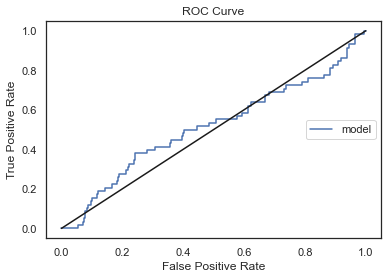

Calculating Savings to component df_generator
Trainning component df_hydraulic

Best Parameters:
 LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)


C:\Users\ricar\code\RicardoJPedro82\wmillfailprev\notebooks\Dataset_transf.py:386: RuntimeWarning: invalid value encountered in longlong_scalars
  'Precision':    cm2[1,1]/(cm2[0,1]+cm2[1,1]) if len(y_test['Pred'].value_counts())>1 else np.nan,
c:\users\ricar\.venvs\lewagon\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


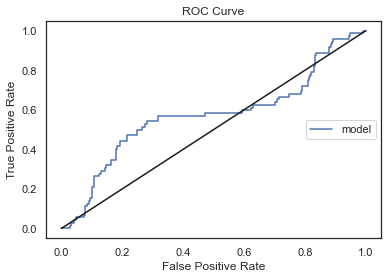

Calculating Savings to component df_hydraulic
Trainning component df_gen_bear

Best Parameters:
 LogisticRegression(C=10, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


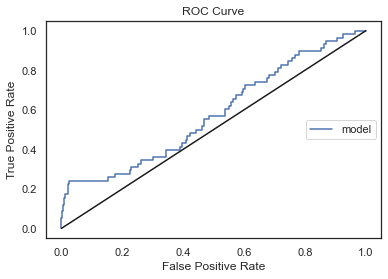

Calculating Savings to component df_gen_bear
Trainning component df_transformer

Best Parameters:
 LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=42,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)


c:\users\ricar\.venvs\lewagon\lib\site-packages\sklearn\model_selection\_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


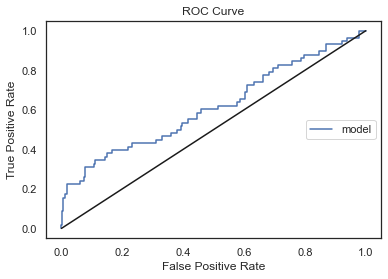

Calculating Savings to component df_transformer
Trainning component df_gearbox

Best Parameters:
 LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)


c:\users\ricar\.venvs\lewagon\lib\site-packages\sklearn\metrics\ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


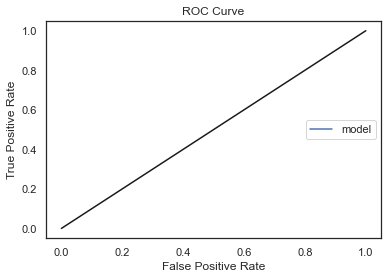

Calculating Savings to component df_gearbox


In [54]:
# Correr o mesmo modelo para todos os componentes
for key in x_train:
    print(f'Trainning component {key}')
    # Train the model
    model_name = 'Logistic Regression'
    clf_LogReg = LogisticRegression(random_state=42, max_iter=1000)
    gs_params = {
        'C': [.01, 0.1, 1.0, 10],
        'solver': ['liblinear', 'lbfgs'],
        'class_weight': [None, 'balanced']
    }
    gs_score = 'roc_auc'

    clf_LogReg, pred_LogReg = dprep.bin_classify(model_name,
                                                 clf_LogReg,
                                                 x_train[key],
                                                 x_test[key],
                                                 y_train[key],
                                                 y_test[key],
                                                 params=gs_params,
                                                 score=gs_score)
    print('\nBest Parameters:\n', clf_LogReg)
    # Obtain metrics
    metrics_dict_miguel = dprep.metrics(y_test[key], pred_LogReg.y_pred,
                                        pred_LogReg.y_score)
    conf_matrix = dprep.conf_matrix(y_test[key], pred_LogReg.y_pred)
    dprep.roc_curve_plot(y_test[key], pred_LogReg.y_score)

    print(f'Calculating Savings to component {key}')
    # Calculate savings
    sav, cf_numb, met_df, dias = dprep.metrics_create_df(df_test_dict[key],
                                                   y_test[key],
                                                   pred_LogReg.y_pred.values,
                                                   key, 15)

    # Store metrics to compare
    metrics_dict['try_' + str(tentativa)] = {
        'Componente': key,
        'Nome_modelo': model_name,
        'dias_var_alvo': col_to_mantain_test,
        'feature_selection': 'Guilherme',
        'Agrup_por': Agrup_por,
        'add_features': 'smooth only',
        'per_test': per_test,
        'model': model_name,
        'Metrics': metrics_dict_miguel,
        'cf_matriX_log_reg': conf_matrix,
        'Savings': sav,
        'cf_bussines_numbers': cf_numb
    }
    tentativa = tentativa + 1

In [55]:
Savings = 0
for i in metrics_dict:
    if metrics_dict[i]['Nome_modelo'] == 'Logistic Regression':
        Savings = Savings + metrics_dict[i]['Savings']
        print(metrics_dict[i]['Componente'], metrics_dict[i]['Savings'])
Savings        

df_generator 15000.0
df_hydraulic -20000
df_gen_bear -30125.0
df_transformer 13575.000000000004
df_gearbox -15000


-36550.0

In [62]:
for key in metrics_dict:
#     if metrics_dict[key]['Componente'] == 'df_hydraulic':
#     print()
    print(metrics_dict[key]['Nome_modelo'], metrics_dict[key]['Componente'], metrics_dict[key]['Savings'])
#               metrics_dict[key]['cf_matriX_log_reg'],
#               metrics_dict[key]['cf_bussines_numbers'])

Logistic Regression df_generator 15000.0
Logistic Regression df_hydraulic -20000
Logistic Regression df_gen_bear -30125.0
Logistic Regression df_transformer 13575.000000000004
Logistic Regression df_gearbox -15000
Random_Forest_Classifier df_generator -60000
Random_Forest_Classifier df_hydraulic -20000
Random_Forest_Classifier df_gen_bear -30000
Random_Forest_Classifier df_transformer -50000
Random_Forest_Classifier df_gearbox 0
Gradient_Boosting_Classifier df_generator -21500.0
Gradient_Boosting_Classifier df_hydraulic 1883.3333333333321
Gradient_Boosting_Classifier df_gen_bear -15166.666666666666
Gradient_Boosting_Classifier df_transformer -5125.0
Gradient_Boosting_Classifier df_gearbox -40000
KNN_Classifier df_generator -12500.0


# Model Training - Random Forrest Classifier

Trainning component df_generator

Best Parameters:
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)


C:\Users\ricar\code\RicardoJPedro82\wmillfailprev\notebooks\Dataset_transf.py:386: RuntimeWarning: invalid value encountered in longlong_scalars
  'Precision':    cm2[1,1]/(cm2[0,1]+cm2[1,1]) if len(y_test['Pred'].value_counts())>1 else np.nan,
c:\users\ricar\.venvs\lewagon\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


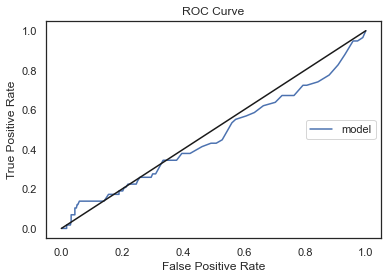

Calculating Savings to component df_generator
Trainning component df_hydraulic

Best Parameters:
 RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=None, oob_score=False,
            random_state=42, verbose=0, warm_start=False)


C:\Users\ricar\code\RicardoJPedro82\wmillfailprev\notebooks\Dataset_transf.py:386: RuntimeWarning: invalid value encountered in longlong_scalars
  'Precision':    cm2[1,1]/(cm2[0,1]+cm2[1,1]) if len(y_test['Pred'].value_counts())>1 else np.nan,
c:\users\ricar\.venvs\lewagon\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


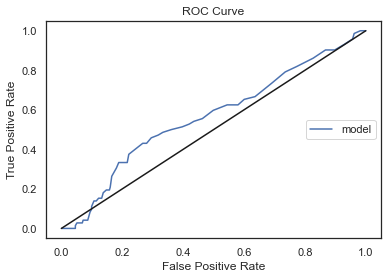

Calculating Savings to component df_hydraulic
Trainning component df_gen_bear

Best Parameters:
 RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=None, oob_score=False,
            random_state=42, verbose=0, warm_start=False)


C:\Users\ricar\code\RicardoJPedro82\wmillfailprev\notebooks\Dataset_transf.py:386: RuntimeWarning: invalid value encountered in longlong_scalars
  'Precision':    cm2[1,1]/(cm2[0,1]+cm2[1,1]) if len(y_test['Pred'].value_counts())>1 else np.nan,
c:\users\ricar\.venvs\lewagon\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


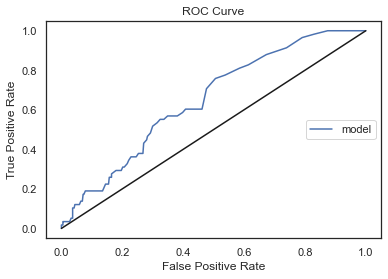

Calculating Savings to component df_gen_bear
Trainning component df_transformer

Best Parameters:
 RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=None, oob_score=False,
            random_state=42, verbose=0, warm_start=False)


C:\Users\ricar\code\RicardoJPedro82\wmillfailprev\notebooks\Dataset_transf.py:386: RuntimeWarning: invalid value encountered in longlong_scalars
  'Precision':    cm2[1,1]/(cm2[0,1]+cm2[1,1]) if len(y_test['Pred'].value_counts())>1 else np.nan,
c:\users\ricar\.venvs\lewagon\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


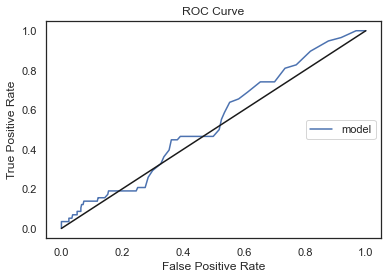

Calculating Savings to component df_transformer
Trainning component df_gearbox

Best Parameters:
 RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=None, oob_score=False,
            random_state=42, verbose=0, warm_start=False)


c:\users\ricar\.venvs\lewagon\lib\site-packages\sklearn\metrics\ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


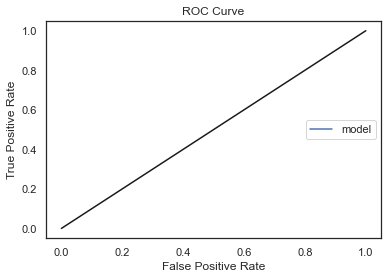

Calculating Savings to component df_gearbox


In [57]:
# Correr o mesmo modelo para todos os componentes
for key in x_train:
    print(f'Trainning component {key}')
    # Train the model
    model_name = 'Random_Forest_Classifier'
    clf_rfc = RandomForestClassifier(random_state=42)
    gs_params = {
        'n_estimators': [300, 500, 750, 800, 900, 1000],
        'criterion': ['gini', 'entropy'],
        'class_weight': ['balanced', None]
    }
    gs_score = 'recall'

    clf_rcf, pred_rcf = dprep.bin_classify(model_name,
                                           clf_rfc,
                                           x_train[key],
                                           x_test[key],
                                           y_train[key],
                                           y_test[key],
                                           params=gs_params,
                                           score=gs_score)
    print('\nBest Parameters:\n', clf_rcf)
    # Obtain metrics
    metrics_dict_miguel = dprep.metrics(y_test[key], pred_rcf.y_pred,
                                        pred_rcf.y_score)
    conf_matrix = dprep.conf_matrix(y_test[key], pred_rcf.y_pred)
    dprep.roc_curve_plot(y_test[key], pred_rcf.y_score)

    print(f'Calculating Savings to component {key}')
    # Calculate savings
    sav, cf_numb, met_df, dias = dprep.metrics_create_df(df_test_dict[key],
                                                   y_test[key],
                                                   pred_rcf.y_pred.values,
                                                   key, 15)

    # Store metrics to compare
    metrics_dict['try_' + str(tentativa)] = {
        'Componente': key,
        'Nome_modelo': model_name,
        'dias_var_alvo': col_to_mantain_test,
        'feature_selection': 'Guilherme',
        'Agrup_por': Agrup_por,
        'add_features': 'smooth only',
        'per_test': per_test,
        'model': model_name,
        'Metrics': metrics_dict_miguel,
        'cf_matriX_log_reg': conf_matrix,
        'Savings': sav,
        'cf_bussines_numbers': cf_numb
    }
    tentativa = tentativa + 1

In [58]:
Savings = 0
for i in metrics_dict:
    if metrics_dict[i]['Nome_modelo'] == 'Random_Forest_Classifier':
        Savings = Savings + metrics_dict[i]['Savings']
        print(metrics_dict[i]['Componente'], metrics_dict[i]['Savings'])
Savings        

df_generator -60000
df_hydraulic -20000
df_gen_bear -30000
df_transformer -50000
df_gearbox 0


-160000

# Model Training - Gradient Boost Classifier

Trainning component df_generator

Best Parameters:
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=42,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)


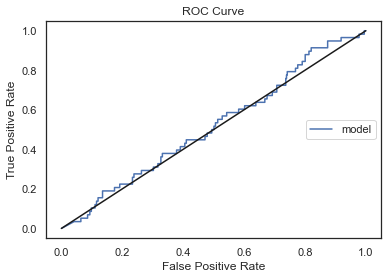

Calculating Savings to component df_generator
Trainning component df_hydraulic

Best Parameters:
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.5, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=42,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)


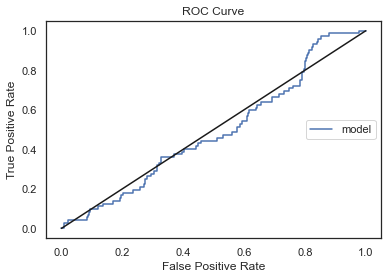

Calculating Savings to component df_hydraulic
Trainning component df_gen_bear

Best Parameters:
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=42,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)


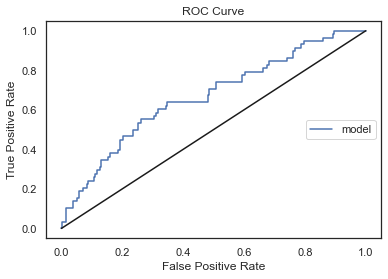

Calculating Savings to component df_gen_bear
Trainning component df_transformer


c:\users\ricar\.venvs\lewagon\lib\site-packages\sklearn\model_selection\_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)



Best Parameters:
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=42,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)


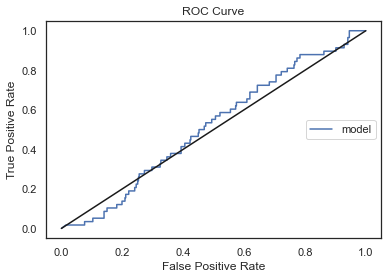

Calculating Savings to component df_transformer
Trainning component df_gearbox

Best Parameters:
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              n_iter_no_change=None, presort='auto', random_state=42,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)


c:\users\ricar\.venvs\lewagon\lib\site-packages\sklearn\metrics\ranking.py:656: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


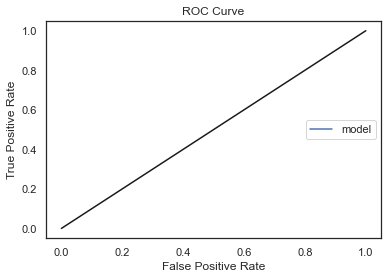

Calculating Savings to component df_gearbox


In [59]:
# Correr o mesmo modelo para todos os componentes
for key in x_train:
    print(f'Trainning component {key}')
    # Train the model
    model_name = 'Gradient_Boosting_Classifier'
    clf_gbc = GradientBoostingClassifier(random_state=42)
    gs_params = {
        'learning_rate': [0.001, 0.01, 0.1, 0.5, 1],
        'n_estimators': [100, 200, 500, 700]
    }
    gs_score = 'recall'

    clf_gbc, pred_gbc = dprep.bin_classify(model_name,
                                           clf_gbc,
                                           x_train[key],
                                           x_test[key],
                                           y_train[key],
                                           y_test[key],
                                           params=gs_params,
                                           score=gs_score)
    print('\nBest Parameters:\n', clf_gbc)
    # Obtain metrics
    metrics_dict_miguel = dprep.metrics(y_test[key], pred_gbc.y_pred,
                                        pred_gbc.y_score)
    conf_matrix = dprep.conf_matrix(y_test[key], pred_gbc.y_pred)
    dprep.roc_curve_plot(y_test[key], pred_gbc.y_score)

    print(f'Calculating Savings to component {key}')
    # Calculate savings
    sav, cf_numb, met_df, dias = dprep.metrics_create_df(df_test_dict[key],
                                                   y_test[key],
                                                   pred_gbc.y_pred.values,
                                                   key, 15)

    # Store metrics to compare
    metrics_dict['try_' + str(tentativa)] = {
        'Componente': key,
        'Nome_modelo': model_name,
        'dias_var_alvo': col_to_mantain_test,
        'feature_selection': 'Guilherme',
        'Agrup_por': Agrup_por,
        'add_features': 'smooth only',
        'per_test': per_test,
        'model': model_name,
        'Metrics': metrics_dict_miguel,
        'cf_matriX_log_reg': conf_matrix,
        'Savings': sav,
        'cf_bussines_numbers': cf_numb
    }
    tentativa = tentativa + 1

In [60]:
Savings = 0
for i in metrics_dict:
    if metrics_dict[i]['Nome_modelo'] == 'Gradient_Boosting_Classifier':
        Savings = Savings + metrics_dict[i]['Savings']
        print(metrics_dict[i]['Componente'], metrics_dict[i]['Savings'])
Savings        

df_generator -21500.0
df_hydraulic 1883.3333333333321
df_gen_bear -15166.666666666666
df_transformer -5125.0
df_gearbox -40000


-79908.33333333334

# Model Training - KNN Classsifier

Trainning component df_generator

Best Parameters:
 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')


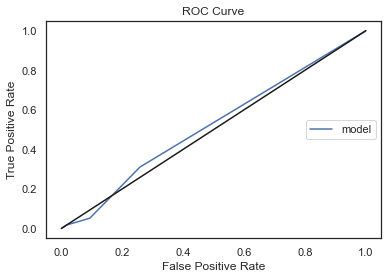

Calculating Savings to component df_generator
Trainning component df_hydraulic

Best Parameters:
 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')


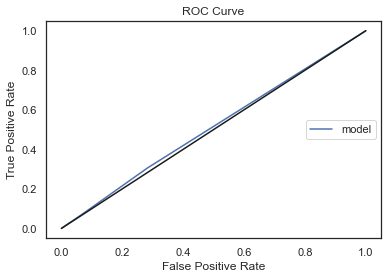

Calculating Savings to component df_hydraulic


IndexError: index 1 is out of bounds for axis 0 with size 1

In [61]:
# Correr o mesmo modelo para todos os componentes
for key in x_train:
    print(f'Trainning component {key}')
    # Train the model
    model_name = 'KNN_Classifier'
    clf_knn = KNeighborsClassifier()
    gs_params = {
        'n_neighbors': [5, 7, 10, 15],
        'weights': ['uniform', 'distance']
    }
    gs_score = 'recall'

    clf_knn, pred_knn = dprep.bin_classify(model_name,
                                           clf_knn,
                                           x_train[key],
                                           x_test[key],
                                           y_train[key],
                                           y_test[key],
                                           params=gs_params,
                                           score=gs_score)
    print('\nBest Parameters:\n', clf_knn)
    # Obtain metrics
    metrics_dict_miguel = dprep.metrics(y_test[key], pred_knn.y_pred,
                                        pred_knn.y_score)
    conf_matrix = dprep.conf_matrix(y_test[key], pred_knn.y_pred)
    dprep.roc_curve_plot(y_test[key], pred_knn.y_score)

    print(f'Calculating Savings to component {key}')
    # Calculate savings
    sav, cf_numb, met_df, dias = dprep.metrics_create_df(df_test_dict[key],
                                                   y_test[key],
                                                   pred_knn.y_pred.values,
                                                   key, 15)

    # Store metrics to compare
    metrics_dict['try_' + str(tentativa)] = {
        'Componente': key,
        'Nome_modelo': model_name,
        'dias_var_alvo': col_to_mantain_test,
        'feature_selection': 'Guilherme',
        'Agrup_por': Agrup_por,
        'add_features': 'smooth only',
        'per_test': per_test,
        'model': model_name,
        'Metrics': metrics_dict_miguel,
        'cf_matriX_log_reg': conf_matrix,
        'Savings': sav,
        'cf_bussines_numbers': cf_numb
    }
    tentativa = tentativa + 1

In [ ]:
Savings = 0
for i in metrics_dict:
    if metrics_dict[i]['Nome_modelo'] == 'KNN_Classifier':
        Savings = Savings + metrics_dict[i]['Savings']
        print(metrics_dict[i]['Componente'], metrics_dict[i]['Savings'])
Savings        

# Model Training - AdaBoostClassifier

In [ ]:
# Correr o mesmo modelo para todos os componentes
for key in x_train:
    print(f'Trainning component {key}')
    # Train the model
    model_name = 'AdaBoostClassifier'
    clf_abc = AdaBoostClassifier(random_state=42)
    gs_params = {'n_estimators': [50, 100, 200, 300, 500]}
    gs_score = 'recall'

    clf_abc, pred_abc = dprep.bin_classify(model_name,
                                           clf_abc,
                                           x_train[key],
                                           x_test[key],
                                           y_train[key],
                                           y_test[key],
                                           params=gs_params,
                                           score=gs_score)
    print('\nBest Parameters:\n', clf_abc)
    # Obtain metrics
    metrics_dict_miguel = dprep.metrics(y_test[key], pred_abc.y_pred,
                                        pred_abc.y_score)
    conf_matrix = dprep.conf_matrix(y_test[key], pred_abc.y_pred)
    dprep.roc_curve_plot(y_test[key], pred_abc.y_score)

    print(f'Calculating Savings to component {key}')
    # Calculate savings
    sav, cf_numb, met_df, dias = dprep.metrics_create_df(df_test_dict[key],
                                                   y_test[key],
                                                   pred_abc.y_pred.values,
                                                   key, 15)

    # Store metrics to compare
    metrics_dict['try_' + str(tentativa)] = {
        'Componente': key,
        'Nome_modelo': model_name,
        'dias_var_alvo': col_to_mantain_test,
        'feature_selection': 'Guilherme',
        'Agrup_por': Agrup_por,
        'add_features': 'smooth only',
        'per_test': per_test,
        'model': model_name,
        'Metrics': metrics_dict_miguel,
        'cf_matriX_log_reg': conf_matrix,
        'Savings': sav,
        'cf_bussines_numbers': cf_numb
    }
    tentativa = tentativa + 1

In [ ]:
Savings = 0
for i in metrics_dict:
    if metrics_dict[i]['Nome_modelo'] == 'AdaBoostClassifier':
        Savings = Savings + metrics_dict[i]['Savings']
        print(metrics_dict[i]['Componente'], metrics_dict[i]['Savings'])
Savings        

In [ ]:
import csv

w = csv.writer(open(nome_ficheiro + ".csv", "w"))
for key, val in metrics_dict.items():
    w.writerow([key, val])

# Cria de DF para avaliação de métricas

In [ ]:
sav

In [ ]:
cf_numb

In [ ]:
met_df[met_df.FP==1][met_df[met_df.FP==1].new_FP==1]